In [1]:
# Author: Vu-Duc Tran
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA


In [103]:
def test_stationarity(timeseries, p=0.05):
    timeseries.dropna(inplace=True)
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    if dftest[1] > p:
        return 0
    else:
        return 1

def take_log_ts(ts):
    ts_log = np.log(ts)
    plt.figure(1)
    plt.subplot(211)
    plt.plot(ts)
    plt.subplot(212)
    plt.plot(ts_log)
    return ts_log

def MA_diff(timeseries, periods=12):
    # Difference from MA 
    moving_avg = timeseries.rolling(periods).mean()
    ts_moving_avg_diff = timeseries - moving_avg
    ts_moving_avg_diff.dropna(inplace=True)
    return moving_avg, ts_moving_avg_diff

def expweighted_diff(timeseries, halflife=12):
    expwighted = timeseries.ewm(halflife)
    expwighted_avg = expwighted.mean()
    ts_expwighted_avg_diff = timeseries - expwighted_avg
    return expwighted_avg, ts_expwighted_avg_diff

def take_diff(ts, order=1, periods=1):
    if order != 0:
        for i in range(order):
            ts = ts - ts.shift(periods=periods)
    return ts

def decomposition_diff(timeseries):   
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return trend, seasonal, residual

def acf_pacf(timeseries, nlags=20):
    lag_acf = acf(timeseries, nlags=nlags)
    lag_pacf = pacf(timeseries, nlags=nlags, method='ols')
    #Plot ACF: 
    plt.subplot(121) 
    plt.bar(range(len(lag_acf)), lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    #Plot PACF:
    plt.subplot(122)
    plt.bar(range(len(lag_pacf)), lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    
    return lag_acf, lag_pacf

def fitting_criterions(ts,order):
    p, d, q = order
    model = ARIMA(ts, order=order).fit()
    aic = model.aic
    bic = model.bic
    ts_diff = take_diff(ts,order=d)
    sse = sum((model.fittedvalues-ts_diff)**2)
    return (p,d,q,sse,aic,bic)

def get_criterions(ts, minp, maxp, mind, maxd, minq, maxq):
    all_cris = []
    for p in range(minp,maxp+1):
        for d in range(mind, maxd+1):
            for q in range(minq, maxq+1):
                try:
                    all_cris.append(fitting_criterions(ts,order=(p,d,q)))
                except:
                    pass
    criterions_dictlist = []
    labels = ['p','d','q','sse','aic','bic']
    for item in all_cris:
        criterion_dict = {}
        for i,value in enumerate(item):
            criterion_dict[labels[i]] = value
        criterions_dictlist.append(criterion_dict)
    return criterions_dictlist

def display_criterions(criterions_dictlist, by='aic'):    
    df = pd.DataFrame(criterions_dictlist)
    df = df.sort_values(by=by)
    return df[:5]

def build_ARIMA(ts, order=(1,0,1)):
    p,d,q = order
    ts_diff = take_diff(ts, order=d)
    model = ARIMA(ts, order=order)
    results = model.fit(disp=-1)
    RSS = np.sqrt(sum((results.fittedvalues-ts_diff)**2))
    plt.plot(ts_diff)
    plt.plot(results.fittedvalues, color='red')
    plt.title('ARIMA(%d,%d,%d) - RSS: %.4f'% (p,d,q,RSS))
    return results, RSS

def take_back_diff(inits, ts_diff, periods=12):
    ext_dates = pd.date_range(start=(inits.index[-1]), end=ts_diff.index[-1], freq=ts_diff.index.freq)
    extended = pd.Series(data=np.nan, index=ext_dates[1:])
    restored = inits.copy()
    restored = restored.append(extended)
    for t in restored.index[periods:]:
        restored[t] = restored[t-pd.DateOffset(months=periods)] + ts_diff[t]
    return restored

def take_back_exp(ts_log):
    ts = np.exp(ts_log)
    return ts

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('data/bbts/AirPassengers.csv', parse_dates=['Month'], 
                   index_col='Month', date_parser=dateparse)
print data.head()

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [4]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=144, freq=None)

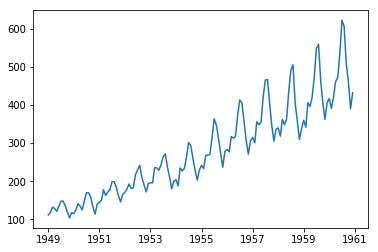

In [5]:
ts = data['#Passengers']
plt.plot(ts)

In [6]:
# #1. Specific the index as a string constant:
# ts['1949-01-01']
# #2. Import the datetime library and use 'datetime' function:
# ts[datetime(1949,1,1)]
# ts['1949']

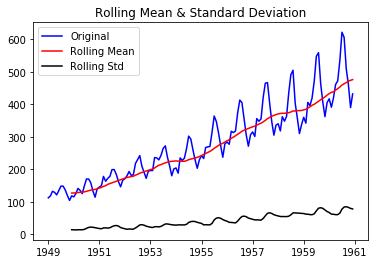

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
t = test_stationarity(ts)

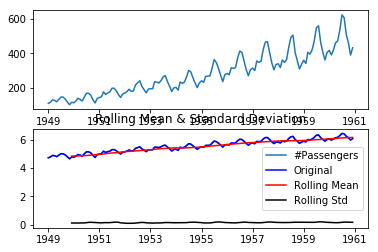

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
# Taking log of time series
ts_log = take_log_ts(ts)
adftest = test_stationarity(ts_log)

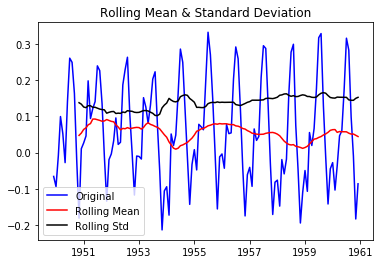

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [9]:
# Eliminate trend by Moving-Average
moving_avg, ts_log_moving_avg_diff = MA_diff(ts_log)
adftest = test_stationarity(ts_log_moving_avg_diff)


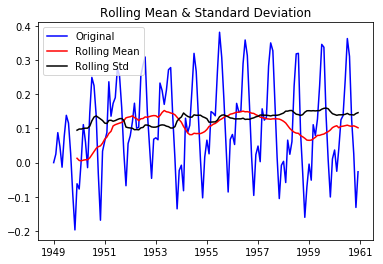

Results of Dickey-Fuller Test:
Test Statistic                  -3.566092
p-value                          0.006443
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
# Eliminate trend by Exponential_Weighted_Moving-Average
expwighted_avg, ts_expwighted_avg_diff = expweighted_diff(ts_log)
adftest = test_stationarity(ts_expwighted_avg_diff)

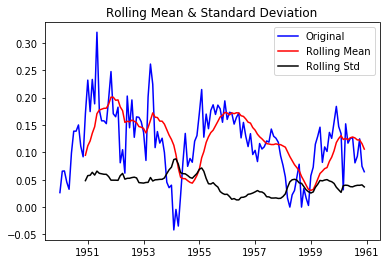

Results of Dickey-Fuller Test:
Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [11]:
# Eliminate trend and seasonal components by differencing
## Eliminate seasonal component (periods = 12 months)
order=1
periods=12
ts_log_noss = take_diff(ts_log, order=order, periods=periods)
adftest = test_stationarity(ts_log_noss)

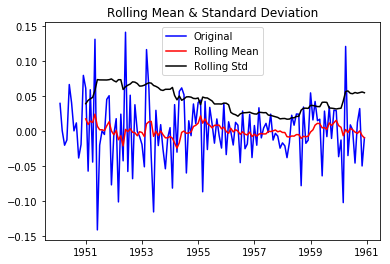

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (5%)             -2.886363
Critical Value (1%)             -3.487022
Critical Value (10%)            -2.580009
dtype: float64


In [12]:
## Eliminate trend
ts_log_diff = take_diff(ts_log_noss, order=1, periods=1)
adftest = test_stationarity(ts_log_diff)

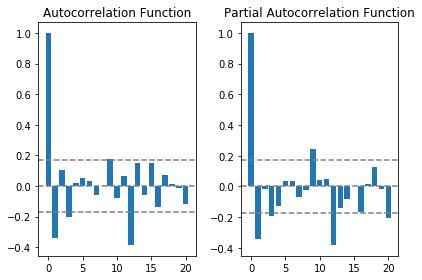

In [13]:
# View ACF-PACF
lag_acf, lag_pacf = acf_pacf(ts_log_diff)

In [14]:
# Chossing model parameters by AIC, BIC criterions
pmin, pmax, dmin, dmax, qmin, qmax = (0,3,0,2,0,3)
criterions_dictlist = get_criterions(ts_log_noss, pmin,pmax, dmin, dmax,qmin, qmax)

/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-

/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-

In [15]:
display_criterions(criterions_dictlist, by='aic')

,aic,bic,d,p,q,sse
28,-467.239434,-444.177019,0,3,3,0.203339
23,-459.559807,-439.433426,1,2,3,NaN
18,-458.262305,-446.731097,0,2,0,0.228856
19,-457.354499,-442.940490,0,2,1,0.227043
11,-457.177441,-445.646233,0,1,1,0.230676


/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


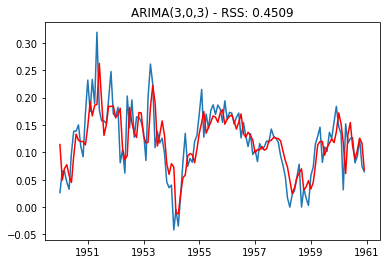

In [105]:
# Estimate ARIMA Model
(p,d,q) = (3,0,3)
model, RSS = build_ARIMA(ts_log_noss, order=(p,d,q))

(array([ 1.        , -0.05739101,  0.0925105 , -0.00998294,  0.05738511,
        -0.03021434,  0.00305485,  0.0630315 ,  0.08016775,  0.0898929 ,
        -0.08747461, -0.03915127, -0.36707236,  0.01700769, -0.08842934,
         0.08601977, -0.11938545,  0.10757968,  0.00942508, -0.08715356,
        -0.1060272 ]),
 array([ 1.00000000e+00, -5.74102344e-02,  9.04328606e-02, -3.14607356e-04,
         4.82985702e-02, -2.38018368e-02, -7.72915400e-03,  7.06378182e-02,
         8.78280147e-02,  9.45999309e-02, -1.07363310e-01, -8.15964627e-02,
        -4.14972789e-01, -3.46128284e-02, -5.47862265e-03,  1.13605949e-01,
        -1.00843908e-01,  8.56498379e-02,  6.69283467e-02, -3.98920103e-02,
        -7.37245024e-02]))

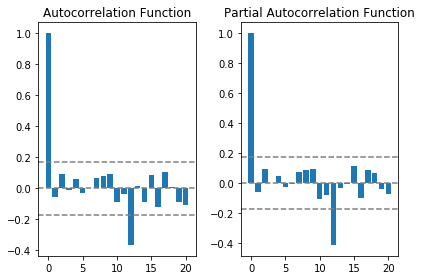

In [17]:
# Residual analysis
acf_pacf(model.resid)

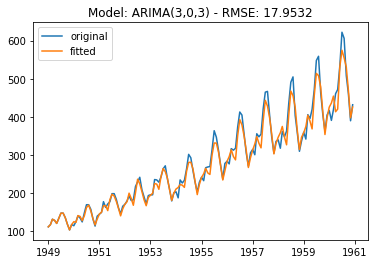

In [109]:
# Return to the original series data
predictions_ts_log = take_back_diff(ts_log, model.fittedvalues, periods=periods)
predictions_ARIMA = take_back_exp(predictions_ts_log)
plt.plot(ts, label='original')
plt.plot(predictions_ARIMA, label='fitted')
plt.title('Model: ARIMA(%d,%d,%d) - RMSE: %.4f'% (p,d,q,np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts))))
plt.legend()

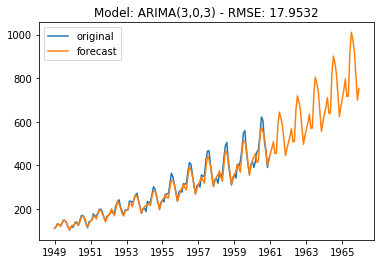

In [111]:
# Forecast
end_date = '1965-12-01'
predictions = model.predict(end=end_date)
predictions_ts_log = take_back_diff(ts_log, predictions, periods=12)
forecast_ARIMA = take_back_exp(predictions_ts_log)
plt.plot(ts, label='original')
plt.plot(forecast_ARIMA, label='forecast')
plt.title('Model: ARIMA(%d,%d,%d) - RMSE: %.4f'% (p,d,q,np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts))))
plt.legend()

In [87]:
pd.date_range(start=ts_diff.index[len(inits)+1], end=ts_diff.index[-1], freq='MS')

DatetimeIndex(['1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01',
               '1962-06-01', '1962-07-01', '1962-08-01', '1962-09-01',
               '1962-10-01', '1962-11-01', '1962-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [89]:
ext_dates = pd.date_range(start=(inits.index[-1]), end=ts_diff.index[-1], freq='MS')
ext_dates[1:]

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
               '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01'],
              dtype='datetime64[ns]', freq='MS')